## **Regressão Linear e Fundamentos de Análise Preditiva**

#### **Conceitos:**

**Análise Preditiva:**

Uso de modelos estatísticos e machine learning para prever TENDÊNCIAS FUTURAS com base em dados históricos. Podemos utilizar, em nosso case de exemplo, para
prever valores de benefícios sociais e identificar padrões de sazonalidade em gastos públicos.

---

**Regressão Linear Simples:**


Técnica estatística que modela a relação linear entre uma variável INDEPENDENTE (X) e uma DEPENDENTE (Y).


Equação: Y = aX + b

a = coeficiente angular (inclinação da reta).

b = intercepto (valor de Y quando X = 0).

---

*Por que é importante conhecermos isso para Big Data?*

- Fácil de implementar e explicar para  TOMADAS DE DECISÃO;

- Serve como fundamento para técnicas avançadas, como as REDES NEURAIS;

- Análise de Tendências: identifica relações entre variáveis em grandes volumes de dados (ex: "Quanto o valor médio do Bolsa Família varia ao longo do tempo?").

In [ ]:
!pip install polars pandas scikit-learn matplotlib seaborn

In [11]:
import polars as pl
from datetime import datetime

# Carregar dados
df = pl.read_parquet("202501_NovoBolsaFamilia_polars.parquet")

# Converter MÊS REFERÊNCIA (Int64) para datetime
df = df.with_columns(
    pl.col("MÊS REFERÊNCIA")
    .cast(pl.Utf8)  # Primeiro converter para string
    .str.strptime(pl.Date, "%Y%m")  # Formato YYYYMM
    .alias("DATA_REF")
)

# Converter VALOR PARCELA para float (tratando vírgula como separador decimal)
df = df.with_columns(
    pl.col("VALOR PARCELA")
    .str.replace(",", ".")
    .cast(pl.Float64)
    .alias("VALOR")
)

# Verificar resultado
print(df.head())

shape: (5, 11)
┌──────────────┬──────────────┬─────┬─────────────┬───┬─────────────┬─────────┬────────────┬───────┐
│ MÊS          ┆ MÊS          ┆ UF  ┆ CÓDIGO      ┆ … ┆ NOME        ┆ VALOR   ┆ DATA_REF   ┆ VALOR │
│ COMPETÊNCIA  ┆ REFERÊNCIA   ┆ --- ┆ MUNICÍPIO   ┆   ┆ FAVORECIDO  ┆ PARCELA ┆ ---        ┆ ---   │
│ ---          ┆ ---          ┆ str ┆ SIAFI       ┆   ┆ ---         ┆ ---     ┆ date       ┆ f64   │
│ i64          ┆ i64          ┆     ┆ ---         ┆   ┆ str         ┆ str     ┆            ┆       │
│              ┆              ┆     ┆ i64         ┆   ┆             ┆         ┆            ┆       │
╞══════════════╪══════════════╪═════╪═════════════╪═══╪═════════════╪═════════╪════════════╪═══════╡
│ 202501       ┆ 202308       ┆ SP  ┆ 7071        ┆ … ┆ FERNANDA    ┆ 650,00  ┆ 2023-08-01 ┆ 650.0 │
│              ┆              ┆     ┆             ┆   ┆ RAMOS       ┆         ┆            ┆       │
│              ┆              ┆     ┆             ┆   ┆ TEIXEIRA    ┆       

Dados para plotagem:
    DATA_REF  VALOR_MEDIO
0 2023-08-01        650.0
1 2023-09-01        650.0
2 2023-10-01        650.0
3 2023-11-01        650.0
4 2023-12-01        650.0


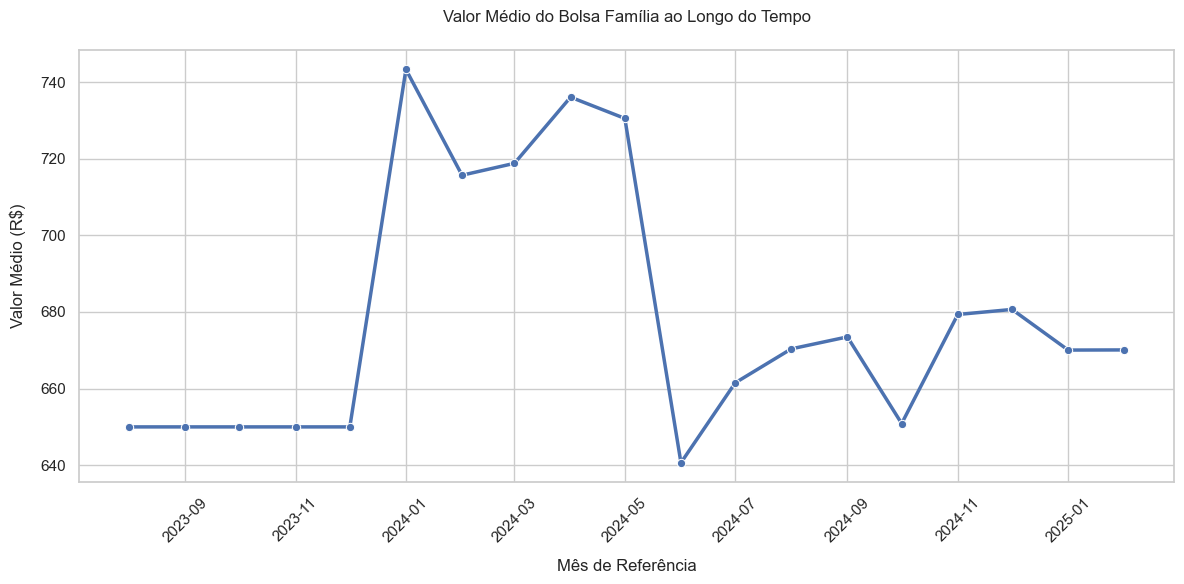

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Certifique-se que os dados estão corretamente agrupados
df_agrupado = df.group_by("DATA_REF").agg(
    pl.col("VALOR").mean().alias("VALOR_MEDIO")
).sort("DATA_REF")

# Converter para Pandas explicitamente
df_plot = df_agrupado.to_pandas()

# Verificar os dados que serão plotados
print("Dados para plotagem:")
print(df_plot.head())

# Configurar o estilo do seaborn
sns.set_theme(style="whitegrid")

# Criar a figura e o eixo explicitamente
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar usando seaborn
sns.lineplot(
    data=df_plot,
    x="DATA_REF",
    y="VALOR_MEDIO",
    ax=ax,  # Especificar o eixo
    marker='o',  # Adicionar marcadores
    linewidth=2.5  # Tornar a linha mais visível
)

# Configurações adicionais
ax.set_title("Valor Médio do Bolsa Família ao Longo do Tempo", pad=20)
ax.set_xlabel("Mês de Referência", labelpad=10)
ax.set_ylabel("Valor Médio (R$)", labelpad=10)
ax.tick_params(axis='x', rotation=45)  # Rotacionar labels do eixo x

# Ajustar layout para evitar cortes
plt.tight_layout()
plt.show()

**Preparação dos Dados para Regressão Linear:**

- Variável Independente (X): Número de meses desde o início da série (para prever tendência temporal);
- Variável Dependente (Y): Valor médio do benefício.

In [26]:
# 1. Converter para tipo Date do Polars se necessário
if df_agrupado["DATA_REF"].dtype != pl.Date:
    df_agrupado = df_agrupado.with_columns(
        pl.col("DATA_REF").cast(pl.Date)
    )

# 2. Calcular usando expressões puras do Polars
df_reg = df_agrupado.with_columns(
    (pl.col("DATA_REF").dt.year() * 12 + pl.col("DATA_REF").dt.month() - 
     (pl.col("DATA_REF").min().dt.year() * 12 + pl.col("DATA_REF").min().dt.month()))
    .alias("MESES_DESDE_INICIO")
)

# 3. Verificar o resultado
print(df_reg.select(["DATA_REF", "MESES_DESDE_INICIO"]).head())

shape: (5, 2)
┌────────────┬────────────────────┐
│ DATA_REF   ┆ MESES_DESDE_INICIO │
│ ---        ┆ ---                │
│ date       ┆ i32                │
╞════════════╪════════════════════╡
│ 2023-08-01 ┆ 0                  │
│ 2023-09-01 ┆ 1                  │
│ 2023-10-01 ┆ 2                  │
│ 2023-11-01 ┆ 3                  │
│ 2023-12-01 ┆ 4                  │
└────────────┴────────────────────┘


Equação da reta: VALOR_MEDIO = 0.19 * MESES_DESDE_INICIO + 676.75
Coeficiente angular (R$/mês): 0.19
Intercepto (valor inicial): R$ 676.75

Métricas de avaliação:
Coeficiente de Determinação (R²): 0.0011
Erro Quadrático Médio (MSE): 1052.83


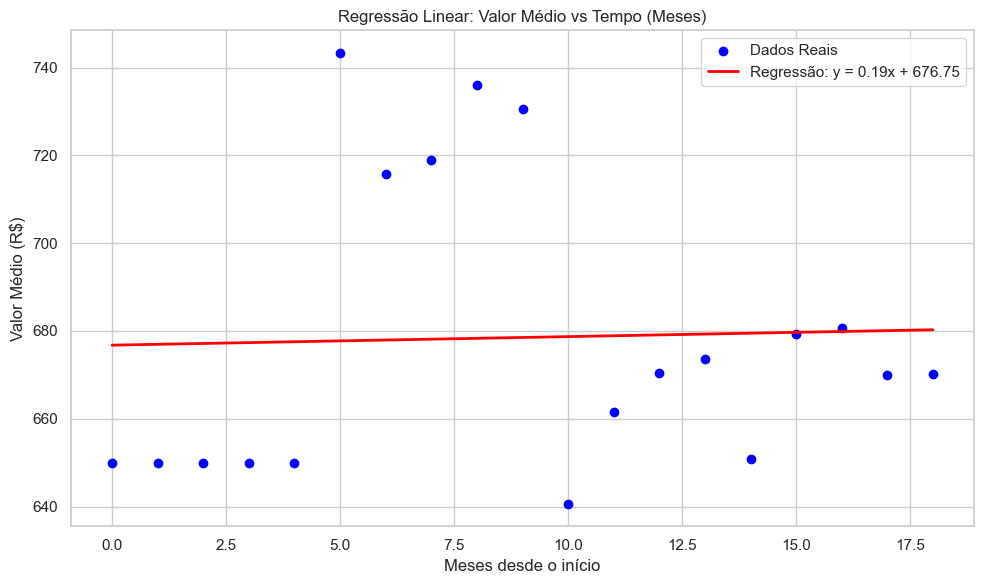

In [27]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

## 1. Preparar os dados para o modelo
# Converter para arrays numpy
X = df_reg["MESES_DESDE_INICIO"].to_numpy().reshape(-1, 1)  # Variável independente (meses)
y = df_reg["VALOR_MEDIO"].to_numpy()                        # Variável dependente (valor)

## 2. Criar e treinar o modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficientes do modelo
inclinacao = modelo.coef_[0]
intercepto = modelo.intercept_

print(f"Equação da reta: VALOR_MEDIO = {inclinacao:.2f} * MESES_DESDE_INICIO + {intercepto:.2f}")
print(f"Coeficiente angular (R$/mês): {inclinacao:.2f}")
print(f"Intercepto (valor inicial): R$ {intercepto:.2f}")

## 3. Fazer previsões
y_pred = modelo.predict(X)

## 4. Avaliar o modelo
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"\nMétricas de avaliação:")
print(f"Coeficiente de Determinação (R²): {r2:.4f}")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

## 5. Visualização dos resultados
plt.figure(figsize=(10, 6))

# Plotar dados reais
plt.scatter(X, y, color='blue', label='Dados Reais')

# Plotar linha de regressão
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regressão: y = {inclinacao:.2f}x + {intercepto:.2f}')

# Configurações do gráfico
plt.title('Regressão Linear: Valor Médio vs Tempo (Meses)')
plt.xlabel('Meses desde o início')
plt.ylabel('Valor Médio (R$)')
plt.grid(True)
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

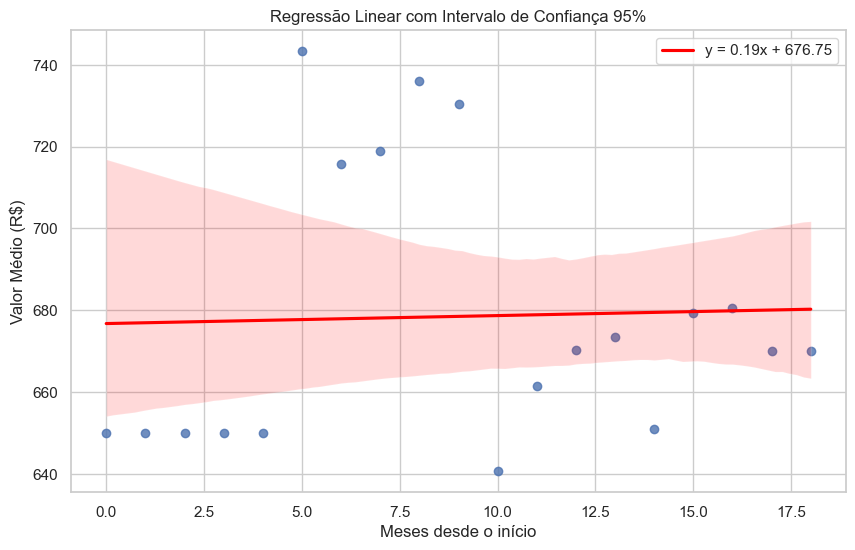

In [29]:
# Versão Alternativa com intervalo de confiança:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x=X.flatten(), y=y, ci=95, 
            line_kws={'color': 'red', 'label': f'y = {inclinacao:.2f}x + {intercepto:.2f}'})
plt.title('Regressão Linear com Intervalo de Confiança 95%')
plt.xlabel('Meses desde o início')
plt.ylabel('Valor Médio (R$)')
plt.legend()
plt.grid(True)
plt.show()


#### **Como interpretamos tudo isso?**

Imagine que você quer criar um **mapa** que mostra como o valor do Bolsa Família muda com o passar do tempo. A regressão linear é como traçar uma **linha reta** que melhor representa essa relação:

- **Eixo X (horizontal)**: Tempo em meses (quanto tempo passou desde o início)
- **Eixo Y (vertical)**: Valor médio do benefício (em reais)

A linha reta vai nos ajudar a **prever** valores futuros com base no passado.

---

#### **A Fórmula Mágica: `y = a*x + b`**

A regressão linear tenta achar a melhor **linha reta** que passa perto de todos os pontos no gráfico. Essa linha tem uma fórmula simples:

`Valor do Benefício = (Inclinação) × (Tempo) + (Valor Inicial)`

Ou, em linguagem matemática:

`y = a*x + b`

Onde:
- **`a` (Inclinação)**: Diz **quanto o valor aumenta por mês** (em R$).
  - Exemplo: Se `a = 5`, significa que **a cada mês, o valor aumenta R$ 5,00**.
- **`b` (Valor Inicial)**: Diz **qual era o valor no primeiro mês** (quando o tempo era zero).

---

#### **Como o programa acha essa linha? (Método dos Mínimos Quadrados)**
O computador não "chuta" uma linha qualquer. Ele usa um método inteligente para achar a linha que **passa o mais perto possível** de todos os pontos no gráfico.

- **Erro**: A distância entre cada ponto real e a linha.
- **Objetivo**: Achar a linha que **minimiza a soma dos erros ao quadrado** (por isso o nome "mínimos quadrados").

---

#### **Como Saber Se a Linha é Boa? (R² e MSE)**
Nem sempre a linha vai passar **perfeitamente** por todos os pontos. Por isso, usamos duas medidas para ver se a previsão é confiável:

##### **R² (Coeficiente de Determinação)**
- **O que significa?**  
  - Se `R² = 1` → A linha explica **100%** dos dados (perfeito).  
  - Se `R² = 0.8` → A linha explica **80%** dos dados (bom).  
  - Se `R² = 0.2` → A linha explica **20%** dos dados (ruim).  

- **Exemplo**:  
  - Se `R² = 0.9`, significa que **90% da variação no valor do benefício** pode ser explicada pelo tempo. Os outros 10% podem ser por outros fatores (inflação, políticas públicas, etc.).

##### **MSE (Erro Quadrático Médio)**
- **O que significa?**  
  - Mede **o tamanho médio dos erros** entre os valores reais e a linha.  
  - Quanto **menor**, melhor.  

- **Exemplo**:  
  - Se `MSE = 100`, significa que, em média, a previsão erra por **±R$ 10** (porque √100 = 10).  

---

#### **O Gráfico**
Quando você vê o gráfico, repare em:

1. **Pontos Azuis**: São os **valores reais** (o que realmente aconteceu).  
2. **Linha Vermelha**: É a **previsão do modelo** (a tal "linha reta").  

Se os pontos estão **pertos da linha**, o modelo é bom. Se estão **muito espalhados**, a previsão pode não ser tão precisa.

---

#### **Exemplo Prático (Bolsa Família)**
Suponha que o modelo encontrou:
- **Inclinação (`a`)** = `5,32` (o valor aumenta **R$ 5,32 por mês**).  
- **Intercepto (`b`)** = `150,00` (no primeiro mês, o valor era **R$ 150,00**).  
- **R²** = `0,85` (o tempo explica **85%** da variação).  

Isso significa:
- A cada mês, o valor sobe **R$ 5,32**.  
- Se hoje são **10 meses** desde o início, o valor previsto é:  
  `150,00 + 5,32 × 10 = R$ 203,20`.  
- Como **R² = 0,85**, a previsão é **confiável**, mas outros fatores (como inflação) podem influenciar os 15% restantes.  

---

#### **Resumindo!**
 **Regressão Linear** → Acha uma **linha reta** que melhor representa a relação entre **tempo** e **valor do benefício**.  
 **Inclinação (`a`)** → Diz **quanto o valor aumenta por mês**.  
 **Intercepto (`b`)** → Diz **qual era o valor no começo**.  
 **R²** → Mostra **quão boa é a linha** (de 0% a 100%).  
 **MSE** → Mostra **o tamanho do erro médio**.  

---

##### **Próximos Passos**
Para melhorar a previsão, poderíamos considerar outros fatores, como:
- **Inflação**  
- **Mudanças na política pública**  
- **Número de beneficiários**  

Mas isso já seria uma **regressão múltipla** (mais complexa). Por enquanto, a regressão simples já nos dá uma ideia suficiente para as primeiras previsões.

---

### **Atividade Prática: Análise Comparativa do Bolsa Família entre Regiões**

Compare a evolução temporal do valor médio do benefício do Bolsa Família em diferentes localidades, identificando padrões regionais e criando hipóteses para explicar as diferenças observadas.

#### **Tarefas**

##### **1. Seleção e Preparação dos Dados**  
- Selecione três municípios ou estados de diferentes regiões do Brasil (ex.: um da região Norte, um do Nordeste e um do Sudeste).  
- Certifique-se de que:  
  - A coluna de data esteja no formato correto  
  - Os valores monetários estejam como números decimais  
  - Os dados estejam filtrados apenas para as localidades escolhidas  

##### **2. Análise Descritiva**  
Para cada localidade selecionada:  
- Calcule estatísticas básicas:  
  - Valor médio do benefício  
  - Valor mínimo e máximo  
  - Número total de beneficiários  
- Crie um gráfico de linha mostrando a evolução do valor médio ao longo do tempo  
- Compare visualmente as trajetórias entre as diferentes localidades  

##### **3. Modelagem Preditiva**  
Para cada localidade:  
- Transforme as datas em uma variável numérica simples (como "meses desde o início da série")  
- Aplique regressão linear para modelar a relação entre tempo e valor do benefício  
- Registre:  
  - Taxa de crescimento mensal (inclinação da reta)  
  - Valor inicial médio  
  - Qualidade do ajuste (R²)  

##### **4. Análise Comparativa**  
Crie uma tabela resumo comparando os resultados das três localidades, destacando:  
- Qual teve o maior crescimento mensal  
- Qual teve o valor inicial mais alto  
- Qual modelo apresentou melhor ajuste aos dados  

![Descrição da imagem](https://pan-art-connections.com/wp-content/uploads/2024/03/PAN_WarnerBros-53.webp)